In [1]:
import xarray as xr
import dask
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import os, sys, glob, re, time, math, calendar

# import custom functions
sys.path.append('/')
from libraries import *
from plotters import *

In [43]:
# === Input parameters ===
input_file = 'data/ERA5.nc'
input_variables = [
    "10ws", "100ws", "100alpha", "975ws", "950ws", "975wsgrad", "950wsgrad",
    "zust", "i10fg", "t2m", "skt", "stl1", "d2m", "msl", "blh", "ishf", 
    "ie", "tcc", "lcc", "cape", "bld", "t_975", "t_950", "2mtempgrad", 
    "sktempgrad", "dewtempsprd", "975tempgrad", "950tempgrad", "sinHR", 
    "cosHR", "sinJDAY", "cosJDAY"
]
input_times_freq = 1 #ratio between the target times and input times, 12 for NOW23 data
target_variables = [0,1,2,3,4]

experiment = f'ERA5_to_profilers'
tabnet_param_file = 'best_model_params.csv'
hourly_data_method = 'Averaged_over_55th_to_5th_min'
segregated = 'segregated'
transformed = 'not_transformed'
loss_function = 'MSE_loss'
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

test_station_ids = ['PROF_WANT','PROF_BRON','PROF_REDH','PROF_JORD']
test_station_ids = ['PROF_WANT']
test_dates_range = ('2018-01-01T00:00:00', '2020-12-31T23:00:00')

X_test_all, Y_test_all = [], []
profiler_data_all, NOW23_data_all = [], []
profiler_true_data_all, NOW23_true_data_all = [], []
for station_id in test_station_ids:
    Coeff_file = f'data/Profiler_Chebyshev_Coefficients_with_outliers/{hourly_data_method}/{station_id}.nc'

    if segregated == 'segregated':
        segregate_arg = True
    else:
        segregate_arg = None
    X_test, Y_test, time_coord = data_processing(input_file,Coeff_file,
                                    input_times_freq,input_variables,target_variables,test_dates_range,station_id,val_arg=None, segregate_arg=segregate_arg)
    print(X_test.shape, Y_test.shape)
    # Collect testing data for all stations
    X_test_all.append(X_test)
    Y_test_all.append(Y_test)

    # profiler and NOW23 data
    profiler_ds = xr.open_dataset(f'data/Profiler_Chebyshev_Coefficients_with_outliers/{hourly_data_method}/{station_id}.nc').Chebyshev_Coefficients
    NOW23_ds = xr.open_dataset(f'data/NOW23_Chebyshev_Coefficients/{station_id}.nc').Chebyshev_Coefficients

    profiler_data = profiler_ds.sel(time=slice(*test_dates_range,input_times_freq)).where(profiler_ds.outlier == 1, drop=True)
    profiler_data = profiler_data.sel(time=time_coord)
    NOW23_data = NOW23_ds.sel(time=time_coord)
    profiler_data_all.append(profiler_data)
    NOW23_data_all.append(NOW23_data)

    # true profiler and NOW23 data
    profiler_profiles_ds = xr.open_dataset(f'data/NYSM_standard_and_profiler_combined_wind_speed/Averaged_over_55th_to_5th_min/{station_id}.nc').wind_speed
    NOW23_profiles_ds = xr.open_dataset(f'data/NOW23_profiles/{station_id}.nc').wind_speed

    profiler_true_data = profiler_profiles_ds.sel(range=slice(10,500),time=time_coord).T
    NOW23_true_data = NOW23_profiles_ds.sel(time=time_coord)
    profiler_true_data_all.append(profiler_true_data)
    NOW23_true_data_all.append(NOW23_true_data)


Segregated times: 18446
Intersected times: 18043
(18043, 32) (18043, 5)


In [44]:
if len(test_station_ids) > 1:
    X_test = np.concatenate(X_test_all, axis=0)
    Y_test = np.concatenate(Y_test_all, axis=0)
    profiler_data = xr.concat(profiler_data_all, dim='time')
    NOW23_data = xr.concat(NOW23_data_all, dim='time')
    profiler_true_data = xr.concat(profiler_true_data_all, dim='time')
    NOW23_true_data = xr.concat(NOW23_true_data_all, dim='time')
else:
    X_test = X_test_all[0]
    Y_test = Y_test_all[0]
    profiler_data = profiler_data_all[0]
    NOW23_data = NOW23_data_all[0]
    profiler_true_data = profiler_true_data_all[0]
    NOW23_true_data = NOW23_true_data_all[0]

print(X_test.shape, Y_test.shape, profiler_data.shape, NOW23_data.shape, profiler_true_data.shape, NOW23_true_data.shape)

(18043, 32) (18043, 5) (18043, 5) (18043, 5) (18043, 18) (18043, 18)


In [45]:
# ML prediction
Ens = 9
model_output_dir = f'trained_models/{experiment}/9_stations/{hourly_data_method}/2021_to_2023/{segregated}/{transformed}/{loss_function}/Ens{Ens}'
fSTR = f'{model_output_dir}/TabNet_HOLDOUT.pkl'
with open(fSTR, "rb") as f:
    tabReg = pickle.load(f)

Y_pred = tabReg.predict(X_test)

if transformed == 'transformed':
    min_max_scaler = joblib.load(f'{model_output_dir}/min_max_scaler.joblib')
    Y_pred = min_max_scaler.inverse_transform(Y_pred)

ML_profile_data = WindProfile(profilers_levels, Y_pred.T, poly_order=4, CPtype=1, ref_H=ref_H)
ML_profile_data = ML_profile_data.T

NOW23_profile_data = WindProfile(profilers_levels, NOW23_data.values.T, poly_order=4, CPtype=1, ref_H=ref_H)
NOW23_profile_data = NOW23_profile_data.T

In [46]:
print(profiler_true_data.shape, ML_profile_data.shape, NOW23_profile_data.shape)
# compute RMSE between profilers_true vs ML and profilers_true vs NOW23
RMSE_ML = np.sqrt(np.nanmean((profiler_true_data.values - ML_profile_data)**2))
RMSE_NOW23 = np.sqrt(np.nanmean((profiler_true_data.values - NOW23_profile_data)**2))
print('Errors between Profilers_true vs ML:', RMSE_ML, 'Errors between Profilers_true vs NOW23:', RMSE_NOW23)

(18043, 18) (18043, 18) (18043, 18)
Errors between Profilers_true vs ML: 2.052308637209767 Errors between Profilers_true vs NOW23: 2.2631702047362


In [47]:
from sklearn.cluster import KMeans
data = profiler_data.values  # Convert to 2D array: [time, coeffs]

# Apply k-means clustering
n_clusters = 64
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(data)  # Specify n_clusters as needed
labels = kmeans.labels_

In [57]:
# save data to numpy file
np.save(f'data.npy', data)

In [48]:
# Add the labels as a new coordinate in the profiler_data
profiler_data = profiler_data.assign_coords(cluster=('time', labels))
NOW23_data = NOW23_data.assign_coords(cluster=('time', labels))
profiler_true_data = profiler_true_data.assign_coords(cluster=('time', labels))
NOW23_true_data = NOW23_true_data.assign_coords(cluster=('time', labels))
X_test = xr.DataArray(X_test, dims=['time','input_features'], coords={'time':profiler_data.time, 'input_features':input_variables}).assign_coords(cluster=('time', labels))
Y_test = xr.DataArray(Y_test, dims=['time','coeff'], coords={'time':profiler_data.time, 'coeff':['C0','C1','C2','C3','C4']}).assign_coords(cluster=('time', labels))

Cluster 0: (366, 18)
Cluster 1: (324, 18)
Cluster 2: (127, 18)
Cluster 3: (693, 18)
Cluster 4: (96, 18)
Cluster 5: (92, 18)
Cluster 6: (348, 18)
Cluster 7: (515, 18)
Cluster 8: (430, 18)
Cluster 9: (233, 18)
Cluster 10: (165, 18)
Cluster 11: (253, 18)
Cluster 12: (540, 18)
Cluster 13: (399, 18)
Cluster 14: (217, 18)
Cluster 15: (404, 18)
Cluster 16: (675, 18)
Cluster 17: (475, 18)
Cluster 18: (148, 18)
Cluster 19: (88, 18)
Cluster 20: (333, 18)
Cluster 21: (174, 18)
Cluster 22: (50, 18)
Cluster 23: (97, 18)
Cluster 24: (136, 18)
Cluster 25: (434, 18)
Cluster 26: (296, 18)
Cluster 27: (170, 18)
Cluster 28: (259, 18)
Cluster 29: (61, 18)
Cluster 30: (249, 18)
Cluster 31: (328, 18)
Cluster 32: (712, 18)
Cluster 33: (192, 18)
Cluster 34: (248, 18)
Cluster 35: (267, 18)
Cluster 36: (213, 18)
Cluster 37: (516, 18)
Cluster 38: (446, 18)
Cluster 39: (420, 18)
Cluster 40: (140, 18)
Cluster 41: (233, 18)
Cluster 42: (142, 18)
Cluster 43: (187, 18)
Cluster 44: (97, 18)
Cluster 45: (387, 18)
Clust

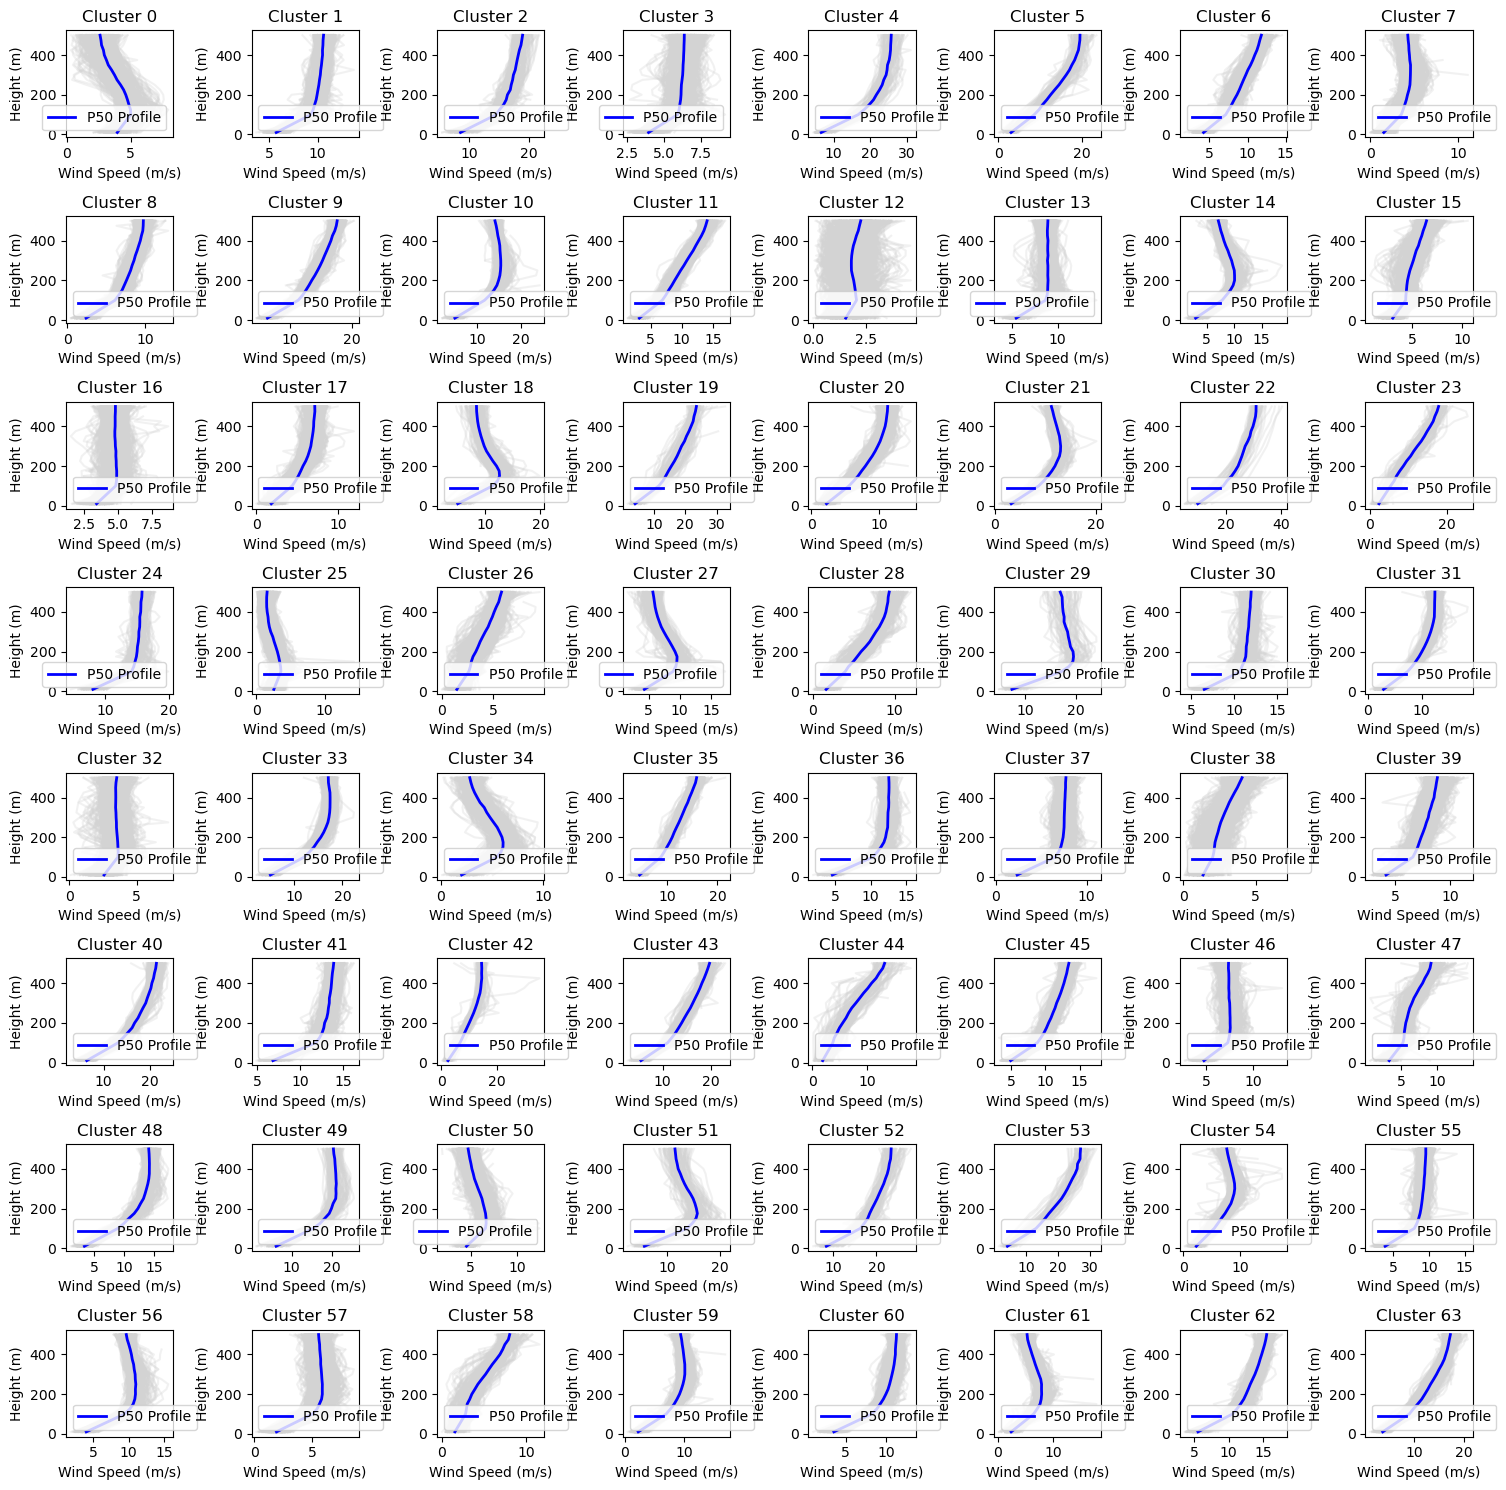

In [49]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(8,8, figsize=(15, 15))
Z = profilers_levels

count = 0
for i in range(n_clusters):
    profile = profiler_true_data.where(profiler_true_data.cluster == i, drop=True)
    count = count+profile.shape[0]
    print(f'Cluster {i}:', profile.shape)

    p50_profile = profile.median(dim='time')

    # Select the current subplot
    ax = axes[i // 8, i % 8]

    # Plot each wind profile in the ensemble in light color
    for prof in profile:
        ax.plot(prof, Z, color='lightgray', alpha=0.3)

    # Plot the P50 profile in a distinct color
    ax.plot(p50_profile, Z, color='blue', linewidth=2, label='P50 Profile')

    # Set labels and title for each subplot
    ax.set_xlabel('Wind Speed (m/s)')
    ax.set_ylabel('Height (m)')
    ax.set_title(f'Cluster {i}')
    ax.legend()

# Adjust layout for better visualization
plt.tight_layout()
plt.show()


In [50]:
# Ensure reproducibility
np.random.seed(42)

# Parameters
Ens = 9
num_samples = 100
selected_clusters = [40, 10, 47, 8]
selected_clusters = [51]
wind_regimes = ['High shear','Well mixed','LLJ','Logertihmic']
wind_regimes = ['LLJ']
z_ml = np.arange(10, 500, 10)  # Height levels for ML profile

# Directory to save figures
save_dir = 'random_samples_plots'
os.makedirs(save_dir, exist_ok=True)

for j, wind_regime in enumerate(wind_regimes):
    # Loop through 50 samples
    fig, axes = plt.subplots(10, 10, figsize=(50, 50), sharey=True)
    axes = axes.flatten()
    for i in range(num_samples):
        cluster = selected_clusters[j]
        # Select random index within the chosen cluster
        random_index = np.random.randint(0, profiler_true_data.where(profiler_true_data.cluster == cluster, drop=True).sizes["time"])
        time_instance = profiler_true_data.where(profiler_true_data.cluster == cluster, drop=True).time[random_index].values

        # Profiler data
        M_profiler = profiler_true_data.sel(time=time_instance).values
        Coeff_profiler = profiler_data.sel(time=time_instance).values
        z_profiler = profilers_levels
        Mp_profiler = WindProfile(z_profiler, Coeff_profiler, poly_order=4, CPtype=1, ref_H=ref_H)
        axes[i].plot(M_profiler, z_profiler, 'or', markerfacecolor='r', label='True profile')
        axes[i].plot(Mp_profiler, z_profiler, '-k', linewidth=2, label='Chebyshev Profile')

        # NOW23 data
        M_NOW23 = NOW23_true_data.sel(time=time_instance).values
        Coeff_NOW23 = NOW23_data.sel(time=time_instance).values
        z_NOW23 = NOW23_levels
        Mp_NOW23 = WindProfile(z_NOW23, Coeff_NOW23, poly_order=4, CPtype=1, ref_H=ref_H)
        axes[i].plot(M_NOW23, z_NOW23, 'ob', markerfacecolor='b', label='NOW23 profile')
        axes[i].plot(Mp_NOW23, z_NOW23, '-g', linewidth=2, label='Chebyshev NOW23 profile')

        # ML prediction
        X = X_test.sel(time=time_instance).values.reshape(1, -1)
        model_output_dir = f'trained_models/{experiment}/9_stations/{hourly_data_method}/2021_to_2023/{segregated}/{transformed}/{loss_function}/Ens{Ens}'
        fSTR = f'{model_output_dir}/TabNet_HOLDOUT.pkl'
        with open(fSTR, "rb") as f:
            tabReg = pickle.load(f)
        
        Y_pred = tabReg.predict(X).reshape(-1, 1)

        if transformed == 'transformed':
            min_max_scaler = joblib.load(f'{model_output_dir}/min_max_scaler.joblib')
            Y_pred = min_max_scaler.inverse_transform(Y_pred)
        
        Mp_ml = WindProfile(z_ml, Y_pred, poly_order=4, CPtype=1, ref_H=ref_H)
        axes[i].plot(Mp_ml, z_ml, '-g', marker='o', markerfacecolor='g', label='ML profile')

        # Set titles, labels, and add legend
        axes[i].set_title(f'{time_instance}')
        axes[i].set_xlabel('Wind Speed (m/s)')
        if i == 0:
            axes[i].set_ylabel('Height (m)')
        axes[i].legend(loc='best')

    # Adjust layout and save plot
    plt.tight_layout()
    fig.savefig(f"{save_dir}/{station_id}_{wind_regime}.png")
    plt.close(fig)

print(f"All {num_samples} sample plots saved to '{save_dir}' directory.")

All 100 sample plots saved to 'random_samples_plots' directory.


In [53]:
profiler_data

<xarray.DataArray 'Chebyshev_Coefficients' (time: 18043, coeff: 5)> Size: 722kB
array([[ 9.10893243e+00,  4.41749607e+00, -1.70113292e+00,
         4.84650183e-01, -2.34820622e-02],
       [ 7.93383981e+00,  4.05319817e+00, -1.14714095e+00,
         4.45187968e-01, -1.91666324e-01],
       [ 8.19416031e+00,  3.96259570e+00, -1.23996632e+00,
         5.54940548e-01, -3.16230003e-01],
       ...,
       [ 2.44365033e+01,  1.10475656e+01, -3.22556753e+00,
         1.29151780e+00, -4.99570492e-01],
       [ 3.00603398e+01,  1.18041202e+01, -3.30486573e+00,
         1.13198947e+00, -4.95307746e-01],
       [ 1.02718003e+01,  2.00741491e+00, -1.76550153e+00,
         9.09012729e-01, -2.65854686e-01]])
Coordinates:
  * time     (time) datetime64[ns] 144kB 2018-01-02 ... 2020-12-01T16:00:00
  * coeff    (coeff) int64 40B 0 1 2 3 4
    outlier  (time) float64 144kB 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    cluster  (time) int32 72kB 31 20 6 60 6 45 11 35 ... 10 40 49 4 4 22 22 30